In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read prepared B data for track-based and vertex-based tagging

In [2]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex.csv')

In [3]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,1,1.091776,111761_12239990,0.959871
1,1,-0.417194,111761_16432326,2.426043
2,-1,1.044602,111761_29035939,1.362860
3,-1,1.062837,111761_30938577,0.543403
4,1,1.076036,111761_4009818,0.992681


In [4]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1.091776,111761_12239990,1.477121
1,1,-0.237732,111761_14379738,0.266671
2,1,-0.442830,111761_33866816,1.398243
3,-1,0.991477,111761_43041334,0.900812
4,-1,1.091055,111761_48273537,0.810535


### Merge two datasets

In [5]:
Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])

In [6]:
Bdata.head()

,Bsign,Bweight_x,event_id,track_relation_prob,Bweight_y,vertex_relation_prob
0,1,1.091776,111761_12239990,0.959871,1.091776,1.477121
1,1,-0.417194,111761_16432326,2.426043,NaN,NaN
2,-1,1.044602,111761_29035939,1.362860,NaN,NaN
3,-1,1.062837,111761_30938577,0.543403,NaN,NaN
4,1,1.076036,111761_4009818,0.992681,NaN,NaN


### Obtain one weight column

In [7]:
Bdata['Bweight'] = Bdata['Bweight_x'].copy()
Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

# for Nan put 1 as non influence factor
Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

In [8]:
Bdata.head()

,Bsign,event_id,track_relation_prob,vertex_relation_prob,Bweight
0,1,111761_12239990,0.959871,1.477121,1.091776
1,1,111761_16432326,2.426043,1.000000,-0.417194
2,-1,111761_29035939,1.362860,1.000000,1.044602
3,-1,111761_30938577,0.543403,1.000000,1.062837
4,1,111761_4009818,0.992681,1.000000,1.076036


In [9]:
relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [10]:
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [11]:
from utils import calibrate_probs
Bprob_calibrated = calibrate_probs(Bsign, Bweight, Bprob)

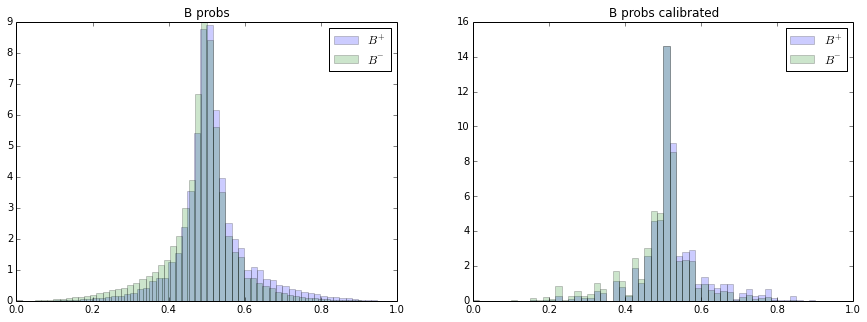

In [12]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(Bprob[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(), title('B probs')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], bins=60, alpha=0.2, normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')
plt.savefig('img/Bprob_iso_calibrated.png' , format='png')

## AUC score and ROC curve for B+ vs B-

AUC for tagged: 0.596247033085 AUC with untag: 0.579510773884


((0, 1), (0, 1))

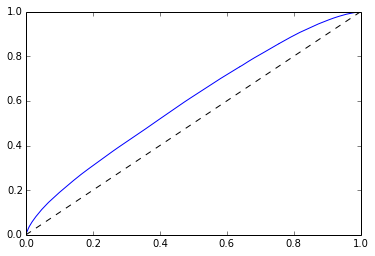

In [ ]:
from utils import calculate_auc_with_and_without_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

fpr, tpr, _ = roc_curve(Bsign, Bprob_calibrated, sample_weight=Bweight)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)

## D2 estimation with bootstrap calibration

In [16]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging')

AUC 0.59661490309 8.33470968803e-07


In [17]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Inclusive tagging,77.789955,0.102331,0.034991,0.000497,2.72191,0.038805,57.951077,0


In [18]:
result.to_csv('img/new-tagging.csv', header=True, index=False)

## Some plots

In [19]:
from utils import calibrate_probs

In [20]:
from sklearn.cross_validation import train_test_split
ind_1, ind_2 = train_test_split(range(len(Bprob)), random_state=13, train_size=0.5)

In [21]:
Bprob_calibrated, (iso_1, iso_2) = calibrate_probs(Bsign, Bweight, Bprob, return_calibrator=True, random_state=13)

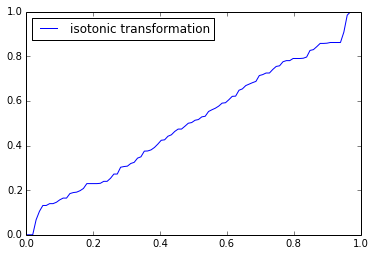

In [22]:
x = numpy.linspace(0, 1, 100)
plot(x, (iso_1.transform(x) + iso_2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plt.savefig('img/iso_transformation.png' , format='png')

In [23]:
import numpy
def compute_mistag(prob, sign, weight, chosen, uniform=True, label=""):
    prob = prob[chosen]
    sign = sign[chosen]
    weight = weight[chosen]
    
    p_mistag = numpy.minimum(prob, 1 - prob)
    tag = numpy.where(prob > 0.5, 1, -1)
    is_correct = (sign * tag > 0) * 1
    
    if uniform:
        bins = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    else:
        bins = numpy.percentile(p_mistag, [5, 10, 20, 40, 60])
    bins_index = numpy.searchsorted(bins, p_mistag)
    right_tagged = numpy.bincount(bins_index, weights=is_correct * weight)
    wrong_tagged = numpy.bincount(bins_index, weights=(1 - is_correct) * weight)
    p_mistag_true = wrong_tagged / (right_tagged + wrong_tagged)
    
    bins = [0.] + list(bins) + [0.5]
    bins = numpy.array(bins)
    bins_centers = (bins[1:] + bins[:-1]) / 2
    bins_error = (bins[1:] - bins[:-1]) / 2
    p_mistag_true_error = numpy.sqrt(wrong_tagged * right_tagged) / (wrong_tagged + right_tagged)**1.5
    errorbar(bins_centers, p_mistag_true, xerr=bins_error, yerr=p_mistag_true_error, fmt='.', label=label)
    plot([0, 1], [0, 1], 'k--')
    xlim(-0.05, 0.55), ylim(-0.05, 1)
    grid()

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


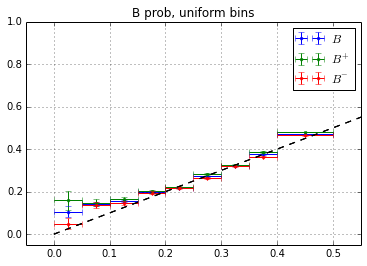

In [24]:
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$")
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$")
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$")
legend(loc='best')
title('B prob, uniform bins')
plt.savefig('img/Bprob_calibration_check_uniform.png' , format='png')

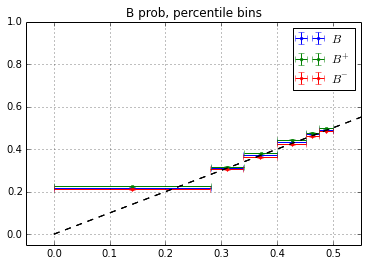

In [25]:
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False)
p1 = compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False)
legend(loc='best')
title('B prob, percentile bins')
plt.savefig('img/Bprob_calibration_check_percentile.png' , format='png')

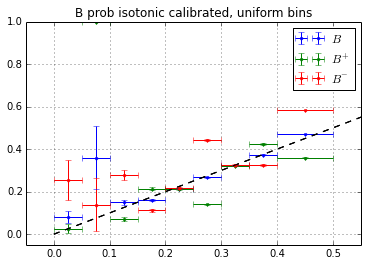

In [26]:
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$")
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$")
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$")
legend(loc='best')
title('B prob isotonic calibrated, uniform bins')
plt.savefig('img/Bprob_calibration_check_iso_uniform.png' , format='png')

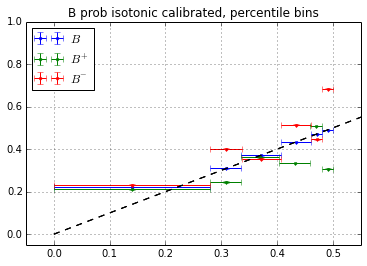

In [27]:
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False)
p2 = compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False)
legend(loc='best')
title('B prob isotonic calibrated, percentile bins')
plt.savefig('img/Bprob_calibration_check_iso_percentile.png' , format='png')